# <center>Time Series and Statistical Arbitrage HW2 </center>

&copy; Kaiwen Zhou 2023

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import colorcet as cc  # nice color pallettes
from scipy.optimize import minimize

# Q2 Topic: MLE for AR and MA processes

## (a) AR(1) process

Suppose we have AR(1) process $X_t=0.9X_{t-1}+Z_t, Z_t \sim IIDN\left(0,0.7^2\right)$. We simulate this process and pretend that we do not know the true values for $\phi$ and $\sigma$.
Then, we use the conditional MLE to estimate the parameter vector $\Psi=\left(\phi, \sigma^2\right)$
By the above deduction, we get the log likelihood function is
\begin{align*}
  \log L(\Psi) &=-\frac{1}{2} \log (2 \pi)-\frac{1}{2} \log \left(\frac{\sigma^2}{1-\phi^2}\right)-\frac{x_1^2}{2 \frac{\sigma^2}{1-\phi^2}}-\frac{n-1}{2} \log (2 \pi)-\frac{n-1}{2} \log \left(\sigma^2\right)-\sum_{i=2}^n \frac{\left(x_i-\phi x_{i-1}\right)^2}{2 \sigma^2}\\
\text{ treat } X_1 \text{ as deterministic } & = -\frac{n-1}{2} \log (2 \pi)-\frac{n-1}{2} \log \left(\sigma^2\right)-\sum_{i=2}^n \frac{\left(x_i-\phi x_{i-1}\right)^2}{2 \sigma^2}
\end{align*}

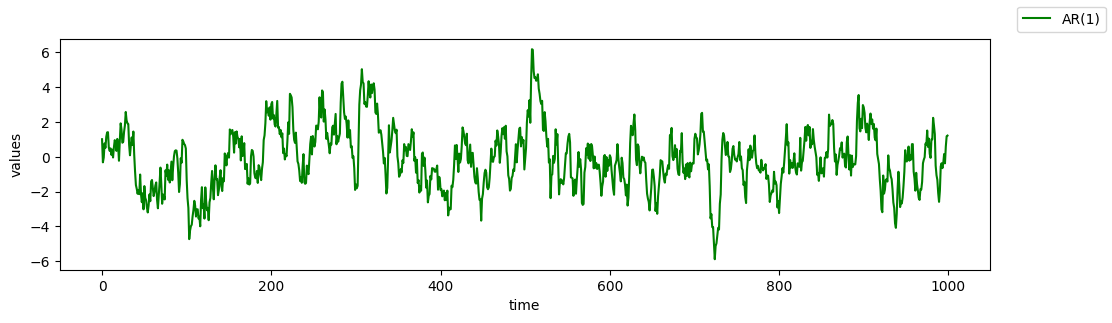

In [2]:
### Auto Regressive ###
np.random.seed(100)

N = 1000
p = 1
sigma = 0.7
phi = 0.9
AR = [1]
for t in range(p, N):
    AR += [ phi * AR[t-p] + np.random.normal(0,sigma) ]

fig = plt.figure(figsize=(12,3))
plt.plot(np.arange(N), AR, label='AR(1)', c='g')
plt.xlabel('time')
plt.ylabel('values')
fig.legend()

Sanity Check: Check the pacf plot so that we are sure that the process we simulated is exactly what we desired.

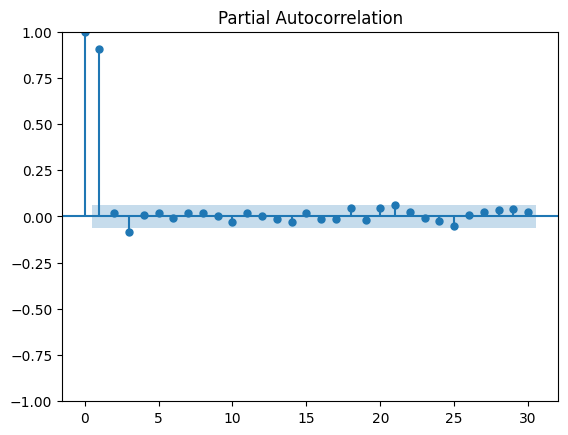

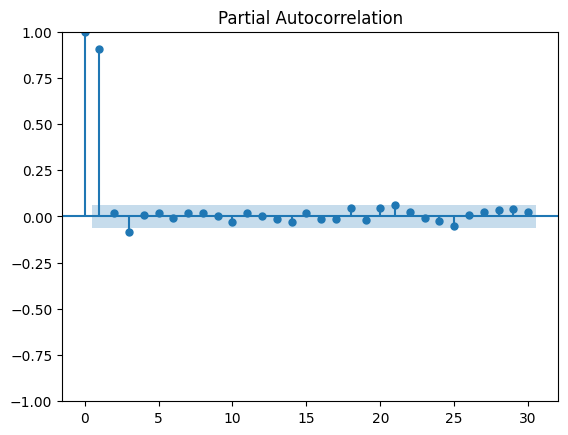

In [3]:
import statsmodels.api as sm

sm.graphics.tsa.plot_pacf(np.array(AR))

### Plot the log-likelihood function and find MLEs

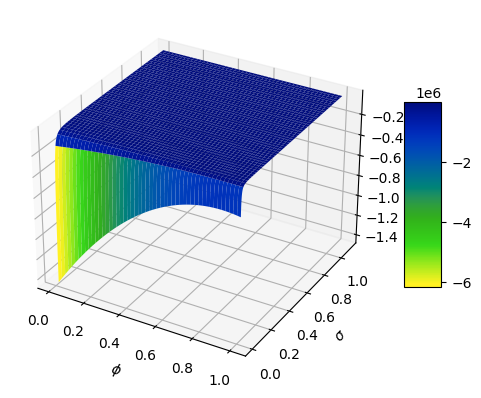

In [4]:
def log_likelihood_AR(phi, sigma):
    n = len(AR)
    return -(n-1)/2 * np.log(2*np.pi) - (n-1)/2 * np.log(sigma ** 2) - sum( (AR[i] - phi * AR[i-1]) ** 2 for i in range(1, n) ) / (2*sigma**2)


# Plot the log-likelihood function
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
x, y = np.meshgrid(np.linspace(0.01,1.01,1000), np.linspace(0.01,1.1,1000))

# Plot the surface.
surf = ax.plot_surface(x, y, log_likelihood_AR(x, y), cmap='cet_linear_bgy_10_95_c74_r')
plt.xlabel('$\phi$')
plt.ylabel('$\sigma$')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

### Find the MLE $\phi_{MLE}$ and $\sigma_{MLE}$.

In [5]:
res = log_likelihood_AR(x, y)
idx = np.unravel_index(np.argmax(res), res.shape)

phi_MLE, sigma_MLE = x[0][idx[1]], y[idx[0]][0]
phi_MLE, sigma_MLE

(0.9048948948948949, 0.7323023023023024)

The result corresponds well with the simulation. Now, we can also do a sanity check on finding MLEs.

### Sanity Check MLEs

In [6]:
from scipy.optimize import minimize

def log_likelihood_AR2(x):
    n = len(AR)
    phi = x[0]
    sigma = x[1]
    likelihood = -(n-1)/2 * np.log(2*np.pi) - (n-1)/2 * np.log(sigma ** 2) - sum( (AR[i] - phi * AR[i-1]) ** 2 for i in range(1, n) ) / (2*sigma**2)
    return -likelihood

x0 = np.array([1, 1])  # initial guess
res = minimize(log_likelihood_AR2, (1, 1), method='SLSQP')

res

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1105.7248301314655
       x: [ 9.053e-01  7.319e-01]
     nit: 9
     jac: [ 5.046e-02 -6.180e-02]
    nfev: 45
    njev: 9

Indeed, our result is correct!

## (b) MA(1) process

Suppose we have MA(1) process $X_t=0.5Z_{t-1}+Z_t, Z_t \sim IIDN\left(0,0.5^2\right)$. We simulate this process and pretend that we do not know the true values for $\phi$ and $\sigma$.
Then, we use the conditional MLE to estimate the parameter vector $\Psi=\left(\theta_1, \sigma^2\right)$
By the above deduction, we get the log likelihood function is
$$
\log L(\Psi)=-\frac{n-1}{2} \log (2 \pi)-\frac{n-1}{2} \log \left(\sigma^2\right)-\sum_{i=2}^n \frac{\left(x_t-\theta_1 z_{t-1}\right)^2}{2 \sigma^2}
$$
Then, we have
$$
\hat{\Psi}_{MLE}=\arg \max_{\Psi} \log L(\Psi)
$$

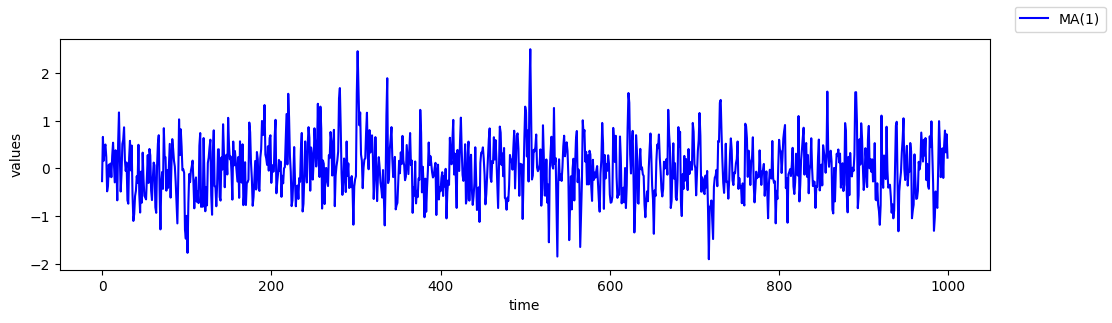

In [7]:
### Moving Average ###
np.random.seed(100)

N = 1000
q = 1
sigma = 0.5
coeff = 0.5
WN = [np.random.normal(0, sigma) for _ in range(N + q)]
MA = []
for t in range(q, N + q):
    MA += [ coeff * WN[t-q] + WN[t]]

fig = plt.figure(figsize=(12,3))
plt.plot(np.arange(N), MA, label='MA(1)', c='b')
plt.xlabel('time')
plt.ylabel('values')
fig.legend()

Sanity Check: Check the acf plot so that we are sure that the process we simulated is exactly what we desired.

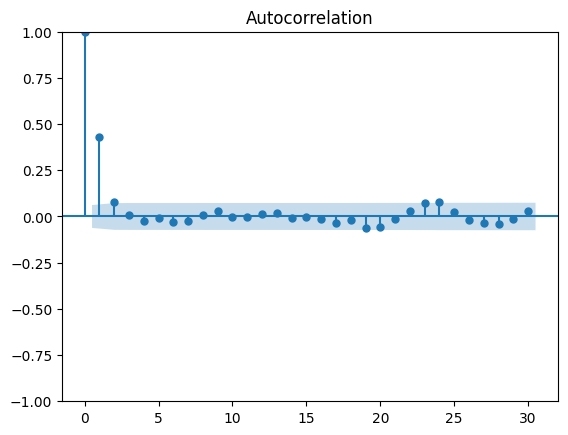

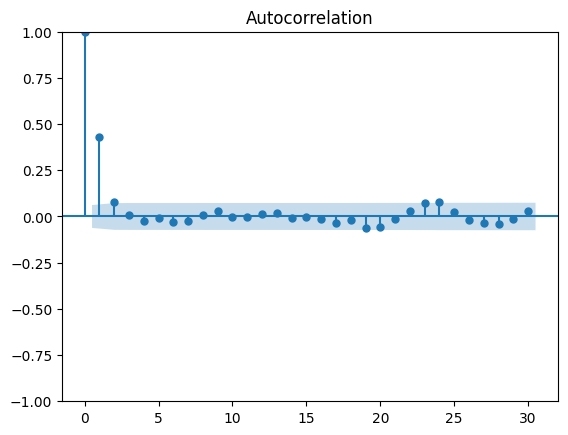

In [8]:
import statsmodels.api as sm

sm.graphics.tsa.plot_acf(np.array(MA))

### Plot the log-likelihood function and find MLEs

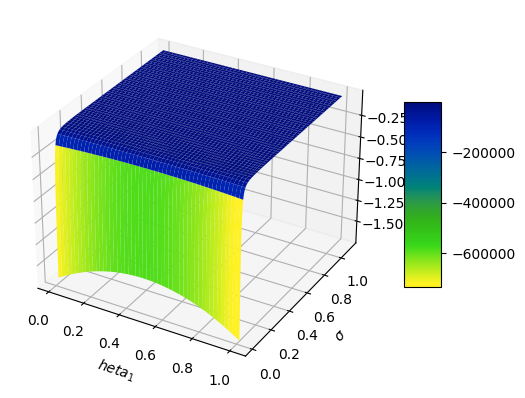

In [9]:
def log_likelihood_MA(theta1, sigma):
    n = len(MA)
    # NOTE: WN[i] = Z_i, MA[i] = X_{i+1}
    return -(n-1)/2 * np.log(2*np.pi) - (n-1)/2 * np.log(sigma ** 2) - sum( (MA[i] - theta1 * WN[i]) ** 2 for i in range(0, n) ) / (2*sigma**2)


# Plot the log-likelihood function
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
x, y = np.meshgrid(np.linspace(0.01,1.01,1000), np.linspace(0.01,1.1,1000))

# Plot the surface.
surf = ax.plot_surface(x, y, log_likelihood_MA(x, y), cmap='cet_linear_bgy_10_95_c74_r')
plt.xlabel('$\theta_1$')
plt.ylabel('$\sigma$')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

### Find the MLE $\theta_{MLE}$ and $\sigma_{MLE}$.

In [10]:
res = log_likelihood_MA(x, y)
idx = np.unravel_index(np.argmax(res), res.shape)

theta1_MLE, sigma_MLE = x[0][idx[1]], y[idx[0]][0]
theta1_MLE, sigma_MLE

(0.4894794794794795, 0.5228128128128129)

The result corresponds well with the simulation. Now, we can also do a sanity check on finding MLEs.

### Sanity Check MLEs

In [11]:
from scipy.optimize import minimize

def log_likelihood_MA2(x):
    n = len(MA)
    theta1 = x[0]
    sigma = x[1]
    likelihood = -(n-1)/2 * np.log(2*np.pi) - (n-1)/2 * np.log(sigma ** 2) - sum( (MA[i] - theta1 * WN[i]) ** 2 for i in range(0, n) ) / (2*sigma**2)
    return -likelihood

x0 = np.array([1, 1])  # initial guess
res = minimize(log_likelihood_MA2, (1, 1), method='SLSQP')

res, res.x

( message: Optimization terminated successfully
  success: True
   status: 0
      fun: 769.0400556237178
        x: [ 4.898e-01  5.225e-01]
      nit: 18
      jac: [-3.967e-04  5.151e-02]
     nfev: 100
     njev: 18,
 array([0.48976682, 0.52250788]))

Indeed, our result is correct!

# Q3: Topic: MLE for AR and MA processes

For the time series model below:
$$
  X_{t}=0.9 X_{t-1}+Z_{t} \quad Z_{t} \text{ is } N\left(0,0.7^{2}\right)
$$

### (I) Simulate a path with 1000 data points.




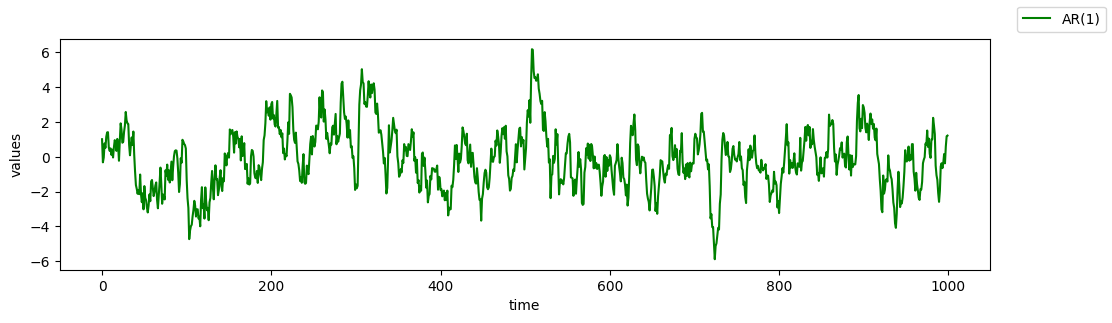

In [12]:
### Auto Regressive ###
np.random.seed(100)

N = 1000
p = 1
sigma = 0.7
phi = 0.9
AR = [1]
for t in range(p, N):
    AR += [ phi * AR[t-p] + np.random.normal(0,sigma) ]

fig = plt.figure(figsize=(12,3))
plt.plot(np.arange(N), AR, label='AR(1)', c='g')
plt.xlabel('time')
plt.ylabel('values')
fig.legend()

### (II) Take the simulated path as the realized data and estimate the parameters using the MLE estimator.

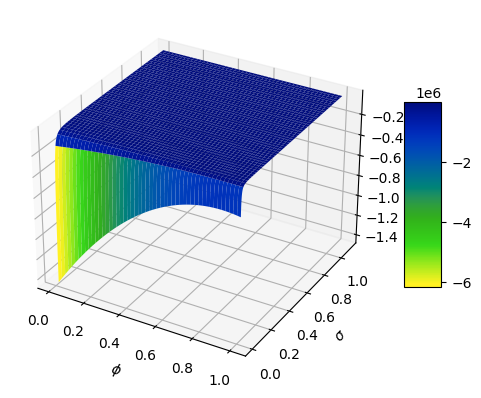

(0.9048948948948949, 0.7323023023023024)

In [13]:
def log_likelihood_AR(phi, sigma):
    n = len(AR)
    return -(n-1)/2 * np.log(2*np.pi) - (n-1)/2 * np.log(sigma ** 2) - sum( (AR[i] - phi * AR[i-1]) ** 2 for i in range(1, n) ) / (2*sigma**2)


# Plot the log-likelihood function
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
x, y = np.meshgrid(np.linspace(0.01,1.01,1000), np.linspace(0.01,1.1,1000))

# Plot the surface.
surf = ax.plot_surface(x, y, log_likelihood_AR(x, y), cmap='cet_linear_bgy_10_95_c74_r')
plt.xlabel('$\phi$')
plt.ylabel('$\sigma$')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

res = log_likelihood_AR(x, y)
idx = np.unravel_index(np.argmax(res), res.shape)

phi_MLE, sigma_MLE = x[0][idx[1]], y[idx[0]][0]
phi_MLE, sigma_MLE

Therefore, the MLE estimators $\phi_{MLE} = 0.9048948948948949$ and $\sigma_{MLE} = 0.7323023023023024$.

### (III) Repeat steps (I) and (II) for 100 times and plot the distributions of the parameters you have estimated. What are the 95% confidence levels around your mean estimated parameters?

In [14]:
def log_likelihood_AR2(x):
    n = len(AR)
    phi = x[0]
    sigma = x[1]
    likelihood = -(n-1)/2 * np.log(2*np.pi) - (n-1)/2 * np.log(sigma ** 2) - sum( (AR[i] - phi * AR[i-1]) ** 2 for i in range(1, n) ) / (2*sigma**2)
    return -likelihood


MLEs_phi = []
MLEs_sigma = []
## 100 times simulation ##
for _ in range(100):
    # simulate 1000 data points for the given process
    N = 1000
    p = 1
    sigma = 0.7
    phi = 0.9
    AR = [1]
    for t in range(p, N):
        AR += [ phi * AR[t-p] + np.random.normal(0,sigma) ]

    x0 = np.array([1, 1])  # initial guess
    res = minimize(log_likelihood_AR2, (1, 1), method='SLSQP')
    MLEs_phi += [ res.x[0] ]
    MLEs_sigma += [ res.x[1] ]


Plots

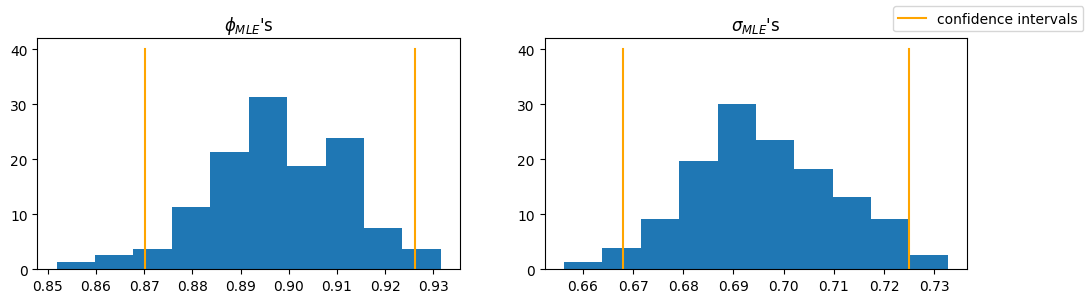

In [15]:
# compute 95% confidence interval for \phi MLEs and \sigma MLEs
CI_phi = np.mean(MLEs_phi) - 1.96*np.std(MLEs_phi), np.mean(MLEs_phi) + 1.96*np.std(MLEs_phi)
CI_sigma = np.mean(MLEs_sigma) - 1.96*np.std(MLEs_sigma), np.mean(MLEs_sigma) + 1.96*np.std(MLEs_sigma)

# Plot \phi MLEs and \sigma MLEs distributions respectively and also their corresponding distributions
fig, axes = plt.subplots(1,2, figsize = (12,3))
axes[0].hist(MLEs_phi, bins = 10, density=True)
axes[0].plot([CI_phi[0]]* 1000, np.linspace(0, 40, 1000), color='orange', label='confidence intervals')
axes[0].plot([CI_phi[1]]* 1000, np.linspace(0, 40, 1000), color='orange')
axes[0].set_title('$\phi_{MLE}$\'s')

axes[1].hist(MLEs_sigma, bins = 10, density=True)
axes[1].plot([CI_sigma[0]]* 1000, np.linspace(0, 40, 1000), color='orange')
axes[1].plot([CI_sigma[1]]* 1000, np.linspace(0, 40, 1000), color='orange')
axes[1].set_title('$\sigma_{MLE}$\'s')
fig.legend()

### (IV) Repeat (III) but use 5000 times instead of 100 times.

In [16]:
def log_likelihood_AR2(x):
    n = len(AR)
    phi = x[0]
    sigma = x[1]
    likelihood = -(n-1)/2 * np.log(2*np.pi) - (n-1)/2 * np.log(sigma ** 2) - sum( (AR[i] - phi * AR[i-1]) ** 2 for i in range(1, n) ) / (2*sigma**2)
    return -likelihood


MLEs_phi = []
MLEs_sigma = []
## 5000 times simulation ##
for _ in range(5000):
    # simulate 1000 data points for the given process
    N = 1000
    p = 1
    sigma = 0.7
    phi = 0.9
    AR = [1]
    for t in range(p, N):
        AR += [ phi * AR[t-p] + np.random.normal(0,sigma) ]

    x0 = np.array([1, 1])  # initial guess
    res = minimize(log_likelihood_AR2, (1, 1), method='SLSQP')
    MLEs_phi += [ res.x[0] ]
    MLEs_sigma += [ res.x[1] ]

Plots

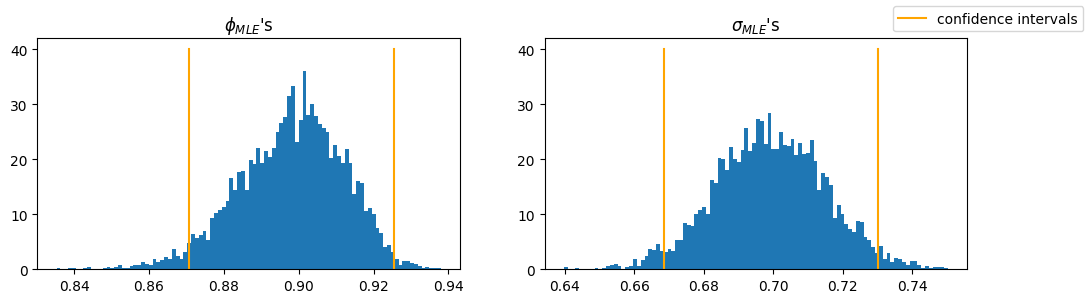

In [17]:
# compute 95% confidence interval for \phi MLEs and \sigma MLEs
CI_phi = np.mean(MLEs_phi) - 1.96*np.std(MLEs_phi), np.mean(MLEs_phi) + 1.96*np.std(MLEs_phi)
CI_sigma = np.mean(MLEs_sigma) - 1.96*np.std(MLEs_sigma), np.mean(MLEs_sigma) + 1.96*np.std(MLEs_sigma)

# Plot \phi MLEs and \sigma MLEs distributions respectively and also their corresponding distributions
fig, axes = plt.subplots(1,2, figsize = (12,3))
axes[0].hist(MLEs_phi, bins = 100, density=True)
axes[0].plot([CI_phi[0]]* 1000, np.linspace(0, 40, 1000), color='orange', label='confidence intervals')
axes[0].plot([CI_phi[1]]* 1000, np.linspace(0, 40, 1000), color='orange')
axes[0].set_title('$\phi_{MLE}$\'s')

axes[1].hist(MLEs_sigma, bins = 100, density=True)
axes[1].plot([CI_sigma[0]]* 1000, np.linspace(0, 40, 1000), color='orange')
axes[1].plot([CI_sigma[1]]* 1000, np.linspace(0, 40, 1000), color='orange')
axes[1].set_title('$\sigma_{MLE}$\'s')
fig.legend()